In [27]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
training_size = 160000
test_portion = 0.1

corpus = []


In [3]:
bdir = 'D:\\Other\\datasets\\'
import gdown
gdown.download(id='1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ', output=bdir)


Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: D:\Other\datasets\training_cleaned.csv
100%|██████████| 239M/239M [01:42<00:00, 2.33MB/s] 


'D:\\Other\\datasets\\training_cleaned.csv'

In [28]:
num_sentences = 0
with open(bdir+"training_cleaned.csv", encoding='utf8') as csvfile:
    reader = csv.reader(csvfile)

    for row in reader:
        list_item = [row[5], 0 if row[0]=='0' else 1]
        num_sentences += 1
        corpus.append(list_item)

In [29]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [30]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, truncating=trunc_type,
                       padding=padding_type, maxlen=max_length)

split = int(test_portion*training_size)

test_sequences = padded[:split]
training_sequences = padded[split:training_size]
test_labels = labels[:split]
train_labels = labels[split:training_size]

In [31]:
print(vocab_size)
print(word_index['i'])

138697
1


In [32]:
gdown.download(id='1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g', output=bdir)

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: D:\Other\datasets\glove.6B.100d.txt
100%|██████████| 347M/347M [01:40<00:00, 3.46MB/s] 


'D:\\Other\\datasets\\glove.6B.100d.txt'

In [35]:
embedding_index = {}
with open(bdir+'glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(len(embedding_matrix))


138698


In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
              metrics = ['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           13869800  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 13,934,953
Trainable params: 65,153
Non-trainable params: 13,869,800
_____________________________________

d:\users\i\pycharmprojects\pythonproject\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [47]:
num_epochs = 5
training_sequences = np.array(training_sequences)
train_labels = np.array(train_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)
history = model.fit(training_sequences, train_labels, epochs=num_epochs,
                    validation_data=(test_sequences, test_labels),
                    verbose=1)

Epoch 1/5
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5722 - accuracy: 0.6960 - val_loss: 0.5288 - val_accuracy: 0.7297

<Figure size 432x288 with 0 Axes>

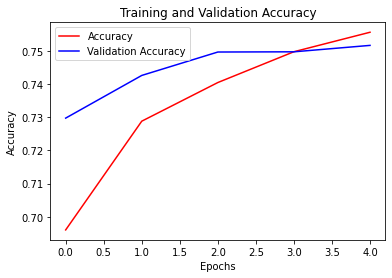

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.figure()

<Figure size 432x288 with 0 Axes>

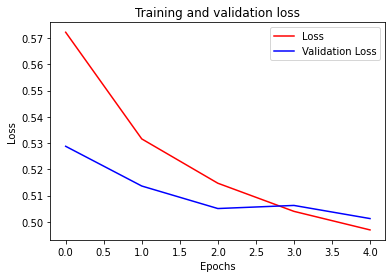

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()